In [60]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import matplotlib.pyplot as plt

In [61]:
# set up the model and data
np.random.seed(5673424)
size = 200
true_intercept = 1
true_slope = 2
sigma = 1
x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + np.random.normal(0, sigma ** 2, size)
s= sigma
#s = np.identity(y.shape[0])
#np.fill_diagonal(s, sigma ** 2)

# reduced dataset
x_coarse_0 = x[::4]
y_coarse_0 = y[::4]
x_coarse_1 = x[::2]
y_coarse_1 = y[::2]
#s_0 = np.identity(y_coarse_0.shape[0])
#np.fill_diagonal(s_0, sigma ** 2)
#s_1 = np.identity(y_coarse_1.shape[0])
#np.fill_diagonal(s_1, sigma ** 2)

# MCMC parameters
ndraws = 1000
ntune = 500
nsub = 5
nchains = 2
seed = 98765

In [62]:
class Likelihood(tt.Op):
    if theano.config.floatX == "float32":
        itypes = [tt.fvector]
        otypes = [tt.fscalar]
    else:
        itypes = [tt.dvector]
        otypes = [tt.dscalar]

    def __init__(self, x, y, pymc3_model):
        self.x = x
        self.y = y
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        temp = intercept + x_coeff * self.x
        self.pymc3_model.Q.set_value(x_coeff)
        outputs[0][0] = np.array(- (0.5 / s ** 2) * np.sum((temp - self.y) ** 2))

In [63]:
'''
class ForwardModel(tt.Op):
    if theano.config.floatX == "float32":
        itypes = [tt.fvector]
        otypes = [tt.fvector]
    else:
        itypes = [tt.dvector]
        otypes = [tt.dvector]

    def __init__(self, x, pymc3_model):
        self.x = x
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        temp = intercept + x_coeff * self.x
        self.pymc3_model.Q.set_value(x_coeff)
        outputs[0][0] = temp
'''

'\nclass ForwardModel(tt.Op):\n    if theano.config.floatX == "float32":\n        itypes = [tt.fvector]\n        otypes = [tt.fvector]\n    else:\n        itypes = [tt.dvector]\n        otypes = [tt.dvector]\n\n    def __init__(self, x, pymc3_model):\n        self.x = x\n        self.pymc3_model = pymc3_model\n\n    def perform(self, node, inputs, outputs):\n        intercept = inputs[0][0]\n        x_coeff = inputs[0][1]\n\n        temp = intercept + x_coeff * self.x\n        self.pymc3_model.Q.set_value(x_coeff)\n        outputs[0][0] = temp\n'

In [64]:
coarse_models = []
mout = []

with pm.Model() as coarse_model_0:            
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s_0)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x_coarse_0, coarse_model_0))
        
    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[0](theta),
    #                      cov=Sigma_e, observed=y_coarse_0)
    
    mout.append(Likelihood(x_coarse_0, y_coarse_0, coarse_model_0))
    pm.Potential('likelihood', mout[0](theta))

    coarse_models.append(coarse_model_0)

with pm.Model() as coarse_model_1:    
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s_1)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x_coarse_1, coarse_model_1))    

    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[1](theta),
    #                      cov=Sigma_e, observed=y_coarse_1)
    
    mout.append(Likelihood(x_coarse_1, y_coarse_1, coarse_model_1))
    pm.Potential('likelihood', mout[1](theta))

    coarse_models.append(coarse_model_1)



In [65]:
with pm.Model() as model:    
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x, model))

    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[2](theta),
    #                      cov=Sigma_e, observed=y)
    
    mout.append(Likelihood(x, y, model))
    pm.Potential('likelihood', mout[2](theta))

    step = pm.MLDA(coarse_models=coarse_models,
                   subsampling_rates=nsub,
                variance_reduction=True,
                store_Q_fine=True)
    
    step2 = pm.DEMetropolisZ()

    trace = pm.sample(draws=ndraws, step=step,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=seed)
    
    trace2 = pm.sample(draws=ndraws, step=step2,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=seed)

/Users/gmingas/projects/pymc3-vr/pymc3/step_methods/metropolis.py:1096: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


The estimated number of effective samples is smaller than 200 for some parameters.


In [66]:
pm.stats.summary(trace)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.200,0.140,0.959,1.480,0.007,0.005,419.0,416.0,419.0,330.0,1.01
x,1.654,0.239,1.181,2.061,0.011,0.008,439.0,439.0,442.0,371.0,1.01


In [67]:
pm.stats.summary(trace2)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.207,0.147,0.929,1.470,0.009,0.007,246.0,246.0,248.0,355.0,1.03
x,1.649,0.254,1.202,2.117,0.034,0.024,56.0,56.0,53.0,273.0,1.05


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

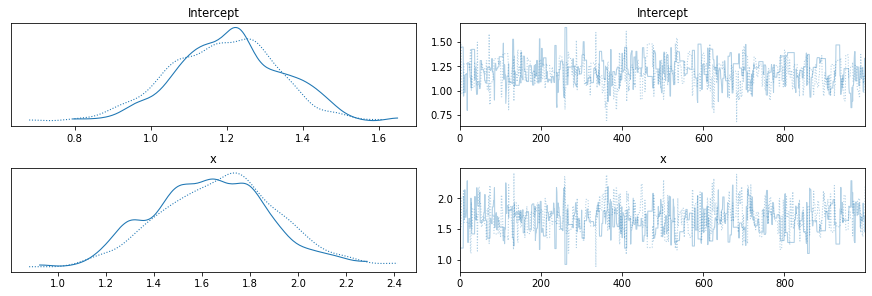

In [68]:
pm.plots.traceplot(trace)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

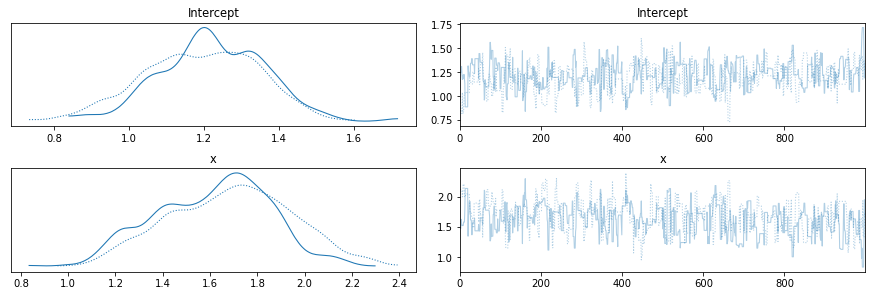

In [69]:
pm.plots.traceplot(trace2)

In [25]:
Q_2 = trace.get_sampler_stats("Q_2").reshape((nchains, ndraws))
Q_0 = np.concatenate(trace.get_sampler_stats("Q_0")).reshape((nchains, ndraws * nsub * nsub))
Q_1_0 = np.concatenate(trace.get_sampler_stats("Q_1_0")).reshape((nchains, ndraws * nsub))
Q_2_1 = np.concatenate(trace.get_sampler_stats("Q_2_1")).reshape((nchains, ndraws))
Q_mean_standard = Q_2.mean(axis=1).mean()
Q_mean_vr = (Q_0.mean(axis=1) + Q_1_0.mean(axis=1) + Q_2_1.mean(axis=1)).mean()

print(f"Q_0 = {Q_0.mean(axis=1)}")
print(f"Q_2 = {Q_2.mean(axis=1).mean()}")
print(f"Q_1_0 = {Q_1_0.mean(axis=1)}")
print(f"Q_2_1 = {Q_2_1.mean(axis=1)}")
print(f"Standard method:    Mean: {Q_mean_standard}")
print(f"VR method:    Mean: {Q_mean_vr}")



Q_0 = [2.00922606 2.01399024]
Q_2 = 1.905780401840735
Q_1_0 = [-0.0407908  -0.04524808]
Q_2_1 = [-0.05713988 -0.06352964]
Standard method:    Mean: 1.905780401840735
VR method:    Mean: 1.9082539464230592


In [30]:
Q_2.shape

(2, 1000)

In [27]:
Q_0.mean(), Q_2.mean(), Q_2_1.mean(), Q_1_0.mean()

(2.0116081497319613,
 1.9057804018407367,
 -0.06033476109064645,
 -0.04301944221825605)

In [36]:
Q_2.var(axis=1), Q_0.var(axis=1), Q_2_1.var(axis=1), Q_1_0.var(axis=1)

(array([0.013973157557529568, 0.01390620024423644], dtype=object),
 array([0.05001042, 0.05395662]),
 array([0.0343502 , 0.03746556]),
 array([0.05018398, 0.0510946 ]))

In [41]:
Q_0.shape

(2, 25000)

In [ ]:
plt.hist(Q_1_0[0,:], bins=500, histtype='step')

In [42]:
import arviz
ess_Q2 = arviz.ess(np.array(Q_2,np.float64))
ess_Q0 = arviz.ess(np.array(Q_0,np.float64))
ess_Q_1_0 = arviz.ess(np.array(Q_1_0,np.float64))
ess_Q_2_1 = arviz.ess(np.array(Q_2_1,np.float64))

In [44]:
ess_Q2, ess_Q0, ess_Q_2_1, ess_Q_1_0

(899.3705803872975, 7940.500552780758, 1519.1360302413964, 6497.822033549085)

In [45]:
Q_2.var()/ess_Q2

1.5541203790502847e-05

In [47]:
Q_0.var()/ess_Q0

6.547344815305412e-06

In [48]:
Q_1_0.var()/ess_Q_1_0

7.794035786743911e-06

In [49]:
Q_2_1.var()/ess_Q_2_1

2.364376109665719e-05